In [110]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib 
%matplotlib inline

In [111]:
columns = ['Class label',
           'Alcohol', 
           'Malic acid',
           'Ash',
           'Alcalinity of ash', 
           'Magnesium', 
           'Total phenols', 
           'Flavanoids', 
           'Nonflavanoid phenols',
           'Proanthocyanins',
           'Color intensity',
           'Hue',
           'OD280/OD315 of diluted wines',
           'Proline']

input_data = pd.read_csv('wine.data', names=columns)

In [102]:
input_data.iloc[:4]

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480


#### Perform Data Preprocessing

In [103]:
# Check if dataframe contains any null values, return false if not
input_data.isnull().values.any()

False

In [104]:
# Standardize the data set
normalized_data = input_data
normalized_attributes = []

for column in columns[1:]:
    curr_col = normalized_data[column]
    
    col_mean = np.mean(curr_col)
    col_var = np.var(curr_col)
    normalized_attributes.append((col_mean, col_var))
    
    normalized_data[column] = (normalized_data[column] - col_mean) / col_var

normalized_data.iloc[:5]

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,1.875889,-0.504711,0.848231,-0.351211,0.134382,1.296282,1.038924,-5.314632,2.146100,0.108885,1.588994,2.610081,0.003226
1,1,0.304233,-0.448305,-3.026609,-0.747964,0.001274,0.911162,0.736539,-6.613196,-0.954397,-0.126882,1.781482,1.572683,0.003074
2,1,0.243198,0.019059,4.054995,-0.080698,0.006204,1.296282,1.220355,-4.016067,3.742395,0.116370,1.396507,1.113835,0.004443
3,1,2.089512,-0.311319,1.783537,-0.243006,0.065363,3.992122,1.472342,-7.911761,1.808422,0.513057,-1.875779,1.672433,0.007434
4,1,0.365268,0.204392,6.727299,0.135713,0.090012,1.296282,0.665983,1.827475,0.703294,-0.138109,1.588994,0.635036,-0.000121


#### Build a kNN models with K=1,2,3,...,10 to classify the quality of the wine

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# Split the input data into input and output matrices
X = normalized_data[normalized_data.columns.tolist()[1:]].values
Y = normalized_data[normalized_data.columns.tolist()[0]].values

In [11]:
knn_models = [None]

for k in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X, Y)
    knn_models.append(knn_model)

#### Build A Decision Tree Model to Classify The Quality of The Wine

In [12]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz

In [13]:
clf = tree.DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=7)
clf = clf.fit(X, Y)

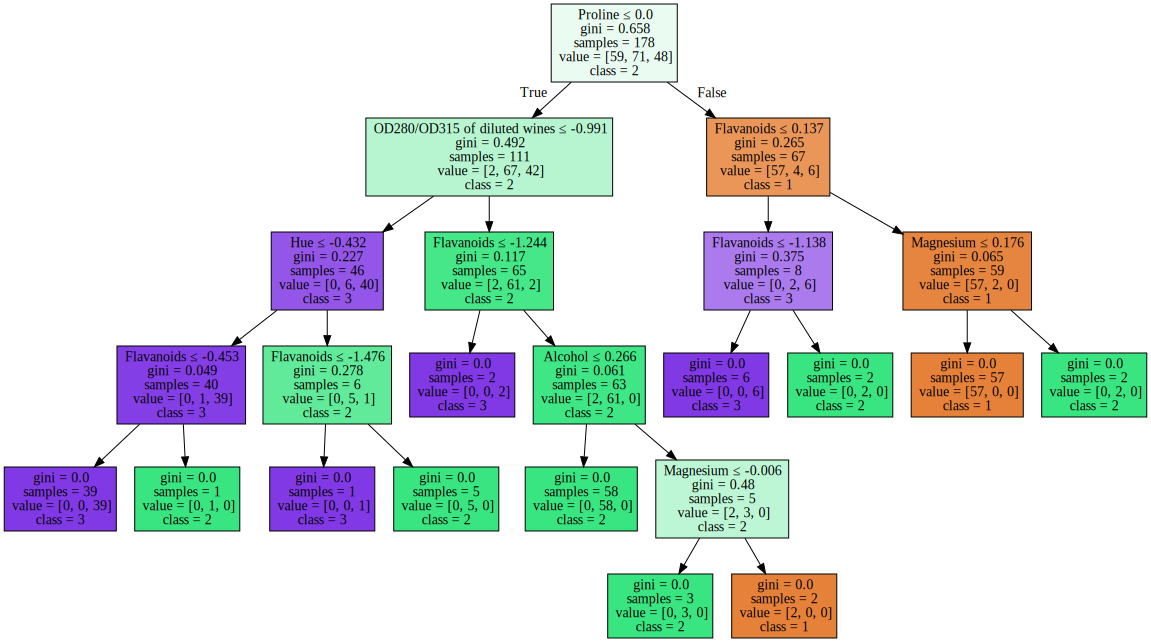

In [14]:
# Get list of the names of attributes and names of the classes
wine_attributes = input_data.columns.tolist()[1:]
wine_target = ["1", "2", "3"]

# Export the decision tree to graph and display
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=wine_attributes,  
                                class_names=wine_target,  
                                filled=True,
                                rounded=False,
                                special_characters=True)

graph = graphviz.Source(dot_data)  
graph

#### Compute the error rate for each model using K-fold cross validation, for K=10. Comment on the results you obtain.

In [83]:
from sklearn.metrics import confusion_matrix

# Perform k fold cross validation using knn models from 1 to neighs neighbors
def k_fold_cv_knn(k, data, neighs):

    avg_error_rate = [None]
    
    for neigh in range(1, neighs+1):

        error_rates = []

        # Permute the data & partition into k parts
        permuted_indices = np.random.permutation(len(input_data))
        dfs = []
        for i in range(k):
            dfs.append(data.iloc[permuted_indices[i::k]])
    
        # Perform K-Fold cross validation
        for i in range(k):
        
            # Get training set
            training_set = []
            for j in range(k):
                if j != i:
                    training_set.append(dfs[j])
            training_set = pd.concat(training_set)
        
            training_X = training_set[training_set.columns.tolist()[1:]].values
            training_Y = training_set[training_set.columns.tolist()[0]].values
    
            # Train on k-1 parts
            knn_model = KNeighborsClassifier(n_neighbors = neigh)
            knn_model.fit(training_X, training_Y)
        
            # Test on the part i
            test_set = dfs[i]
            test_X = test_set[test_set.columns.tolist()[1:]].values
            test_Y = test_set[test_set.columns.tolist()[0]].values
            predicted = knn_model.predict(test_X)
            
            # Compute the error rate for each iteration
            conf_matrix = confusion_matrix(test_Y, predicted)
            accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
            error_rates.append(1-accuracy)
    
        # Compute the average error rate for give model
        avg_error_rate.append(np.mean(error_rates))
    
    # Return the list of error rate for different KNN models
    return avg_error_rate

In [84]:
error_rates = k_fold_cv_knn(k=10, data=normalized_data, neighs=10)
for i in range(1, len(error_rates)):
    print("The error rate for a KNN algorithm with k=%s is: %.5f" % (i, error_rates[i]))

The error rate for a KNN algorithm with k=1 is: 0.15163
The error rate for a KNN algorithm with k=2 is: 0.21405
The error rate for a KNN algorithm with k=3 is: 0.18562
The error rate for a KNN algorithm with k=4 is: 0.18987
The error rate for a KNN algorithm with k=5 is: 0.17451
The error rate for a KNN algorithm with k=6 is: 0.18562
The error rate for a KNN algorithm with k=7 is: 0.16928
The error rate for a KNN algorithm with k=8 is: 0.16895
The error rate for a KNN algorithm with k=9 is: 0.16895
The error rate for a KNN algorithm with k=10 is: 0.16307


In [89]:
# Perform k fold cross validation using decision tree model
def k_fold_cv_decision_tree(k, data):

    error_rates = []

    # Permute the data & partition into k parts
    permuted_indices = np.random.permutation(len(input_data))
    dfs = []
    for i in range(k):
        dfs.append(data.iloc[permuted_indices[i::k]])
    
    # Perform K-Fold cross validation
    for i in range(k):
        
        # Get training set
        training_set = []
        for j in range(k):
            if j != i:
                training_set.append(dfs[j])
        training_set = pd.concat(training_set)
        
        training_X = training_set[training_set.columns.tolist()[1:]].values
        training_Y = training_set[training_set.columns.tolist()[0]].values
    
        # Train on k-1 parts
        tree_model = tree.DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=7)
        tree_model.fit(training_X, training_Y)
        
        # Test on the part i
        test_set = dfs[i]
        test_X = test_set[test_set.columns.tolist()[1:]].values
        test_Y = test_set[test_set.columns.tolist()[0]].values
        predicted = tree_model.predict(test_X)
            
        # Compute the error rate for each iteration
        conf_matrix = confusion_matrix(test_Y, predicted)
        accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
        error_rates.append(1-accuracy)
    
    # Compute the average error rate for the decision tree model
    return np.mean(error_rates)

In [98]:
error_rate = k_fold_cv_decision_tree(k=10, data=normalized_data)
print("The avg error rate for the decision tree model using K-Fold CV with k=10 is: %.5f" % (error_rate))

The avg error rate for the decision tree model using K-Fold CV with k=10 is: 0.08987


It seems that using the decision tree model has the lowest misclassified rate (only 8.987%). With KNN models with k from 1, the error rates is much higher (x2 the error rate when we use the decision tree model). The error rates seem to be high when we do a KNN algorithm with $k\in[2,6]$ 